In [1]:
import os

import pandas as pd
from test.benchmarks.rag.evaluation import init_knowledge_base
from src.agent.knowledge import Store, Topic

In [2]:
knowledge_base: Store = init_knowledge_base({
    '../../../data/json/owasp.json': [Topic.WebPenetrationTesting]
})

Uploading owasp.json: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


### Load Synthetic Dataset

In [3]:
synthetic_qa_paths = [
    '../../../data/rag_eval/owasp_100.json',
    # '../../../data/rag_eval/owasp_100-200.json'
] 

In [4]:
df = pd.concat(
    [pd.read_json(path) for path in synthetic_qa_paths],
    ignore_index=True
)
df

,question,ground_truth
0,How can a security professional choose appropr...,Choose a CSPRNG-based initialization vector fo...
1,"Is any data transmitted in clear text, and are...",The context does not provide any information a...
2,What is the SQL injection vulnerability in the...,The SQL injection vulnerability in the given s...
3,What security measures are implemented to prev...,The context does not provide sufficient inform...
4,What are the key security requirements to be c...,Secure design is a crucial phase in applicatio...
...,...,...
95,What is the vulnerability category that is not...,The vulnerability category that is not include...
96,How can an attacker gain access to a user's au...,The attacker can gain access to the user's aut...
97,What was the position of security logging and ...,The position of security logging and monitorin...
98,What are some prohibited attack scenarios rela...,Scenario #1: A credential recovery workflow mi...


### Retrieve context and generate responses

In [5]:
import textwrap
from datasets import Dataset
from tqdm import tqdm
from src.agent.llm import LLM

In [6]:
sys_prompt = textwrap.dedent("""
You are a Cybersecurity professional assistant, your job is to provide an answer to context specific questions.
You will be provided with additional Context information to provide an answer.
""")

usr_prompt = textwrap.dedent("""
Question: {query}
Context:
{context}
""")

In [7]:
llm = LLM(model='gemma:2b')

def gen_context_answer(question: str):
    points = knowledge_base.retrieve(question, 'owasp')
    context_list = [f'{p.payload["title"]}: {p.payload["text"]}' for p in points]
    context = '\n'.join(context_list)
    answer = llm.query(
        messages=[
            {'role': 'system', 'content': sys_prompt},
            {'role': 'user', 'content': usr_prompt.format(query=question, context=context)}
        ],
        stream=False
    )['message']['content']
    
    return context_list, answer

In [8]:
limit = 101
eval_data = []
for i, items in tqdm(df.iterrows(), total=limit, desc='Retrieving context and generating answers.'):
    if i >= limit:
        break
    ctx, ans = gen_context_answer(items.question)
    eval_data.append({
        'contexts': ctx,
        'question': items.question,
        'answer': ans,
        'ground_truth': items.ground_truth
    })

Retrieving context and generating answers.:  99%|█████████▉| 100/101 [1:07:39<00:40, 40.59s/it]


In [9]:
eval_dataset = pd.DataFrame(eval_data)
eval_dataset

,contexts,question,answer,ground_truth
0,[Cryptographic Failures: * Store passwords usi...,How can a security professional choose appropr...,**How can a security professional choose appro...,Choose a CSPRNG-based initialization vector fo...
1,[Cryptographic Failures: For all such data:\n*...,"Is any data transmitted in clear text, and are...",I am unable to provide a specific answer to th...,The context does not provide any information a...
2,[Vulnerable and Outdated Components: Such flaw...,What is the SQL injection vulnerability in the...,"Sure, here's an answer to the context question...",The SQL injection vulnerability in the given s...
3,[Vulnerable and Outdated Components: * Continu...,What security measures are implemented to prev...,**Security measures to prevent unauthorized ac...,The context does not provide sufficient inform...
4,[Insecure Design: How to Prevent\n* Establish ...,What are the key security requirements to be c...,"Sure, here are the key security requirements t...",Secure design is a crucial phase in applicatio...
...,...,...,...,...
95,[Vulnerable and Outdated Components: It was #2...,What is the vulnerability category that is not...,The vulnerability category that is not include...,The vulnerability category that is not include...
96,[Identification and Authentication Failures: A...,How can an attacker gain access to a user's au...,"Sure, here is how an attacker can gain access ...",The attacker can gain access to the user's aut...
97,[Security Logging and Monitoring Failures: Sec...,What was the position of security logging and ...,"Sure, here's the answer to your question:\n\nI...",The position of security logging and monitorin...
98,[Insecure Design: Limit resource consumption b...,What are some prohibited attack scenarios rela...,"Sure, here are some prohibited attack scenario...",Scenario #1: A credential recovery workflow mi...


### Evaluate with LLM as a judge

In [10]:
import re
import os
import json
from json import JSONDecodeError
from dataclasses import dataclass
from abc import ABC, abstractmethod

import requests
import numpy as np
from dotenv import load_dotenv
load_dotenv()

hf_api_key = os.environ.get('HF_API_KEY')
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.3"
json_pattern = r'{"result": \[[^\]]*\]}'

In [11]:
@dataclass
class HuggingFaceLLM:
    """Represents HuggingFace Inference Endpoint"""
    url: str
    key: str
    
    def __post_init__(self):
        self.headers = {"Authorization": f"Bearer {self.key}", "Content-Type": "application/json"}

    def __query(self, payload):
        response = requests.post(self.url, headers=self.headers, json={'inputs': payload})
        response.raise_for_status()
        return response.json()
    
    def query(self, messages: list):
        prompt = '\n'.join([msg['content'] for msg in messages])
        return self.__query(prompt)

In [12]:
@dataclass
class Metric(ABC):
    """Represents a RAG evaluation metric using LLM-as-a-judge paradigm"""
    system_prompt: str
    user_prompt: str
    llm_provider: HuggingFaceLLM
    
    @abstractmethod
    def compute(self, *args, **kwargs) -> float:
        """Needs to be implemented to evaluate a metric"""
        pass
    
    
class ContextRecall(Metric):
    """Assesses how much the answer is based on the context"""
    
    def compute(self, answer: str, context: str):
        """Computes context recall given answer and context"""
        messages = [
            {'role': 'system', 'content': self.system_prompt},
            {'role': 'user', 'content': self.user_prompt.format(answer=answer, context=context)}
        ]
        
        result = self.llm_provider.query(messages)
        result = result[0]['generated_text'].split('\n')[-1]
        
        try:
            return np.mean(json.loads(result)['result'])
        except JSONDecodeError:
            match = re.search(json_pattern, result)
            if match:
                return np.mean(json.loads(match.group())['result'])
            else:
                return result
    
    
class ContextPrecision(Metric):
    """Assesses how much the context was useful in generating the answer"""
    
    def compute(self, question: str, answer: str, context: str):
        """Uses question, answer and context"""
        messages = [
            {'role': 'system', 'content': self.system_prompt},
            {'role': 'user', 'content': self.user_prompt.format(question=question, answer=answer, context=context)}
        ]
        
        result = self.llm_provider.query(messages)
        result = result[0]['generated_text'].split('\n')[-1]
        
        try:
            return np.mean(json.loads(result)['result'])
        except JSONDecodeError:
            match = re.search(json_pattern, result)
            if match:
                return np.mean(json.loads(match.group())['result'])
            else:
                return result

In [13]:
mistral_context_recall_sys = textwrap.dedent("""
Given a context, and an answer, analyze each sentence in the answer and classify if the sentence can be attributed to the given context or not. Use only "Yes" (1) or "No" (0) as a binary classification. 

Your output should contain a list of 0 or 1 for each sentence, also it should be a JSON string as follows:
{{"result": [1, 0, ...]}}

IMPORTANT:
- Only provide the JSON string in the specified format. Do not include any additional text.
- If the answer mentions that available information wasn't sufficient, your response should be the following: {{"result": [0]}}
""")

mistral_context_recall_usr = textwrap.dedent("""
Answer:
{answer}

Context:
{context}

Your output should contain a list of 0 or 1 for each sentence, also it should be a JSON string as follows:
{{"result": [1, 0, ...]}}

IMPORTANT:
- Only provide the JSON string in the specified format. Do not include any additional text.
- If the answer mentions that available information wasn't sufficient, your response should be the following: {{"result": [0]}}
""")

mistral_context_precision_sys = textwrap.dedent("""
Given question, answer and context verify if the context was useful in arriving at the given answer. 
Use only "Useful" (1) or "Not Useful" (0) as a binary classification. 

Your output should contain a list of 0 or 1 for each sentence, also it should be a JSON string as follows:
{{"result": [1, 0, ...]}}

IMPORTANT:
- Only provide the JSON string in the specified format. Do not include explanations or any additional text.
- If the answer do not provide a response to the question or mentions that available information wasn't sufficient, your response should be the following:  {{"result": [0]}}
""")

mistral_context_precision_usr = textwrap.dedent("""
Question:
{question}

Context:
{context}

Answer:
{answer}

Your output should contain a list of 0 or 1 for each sentence, also it should be a JSON string as follows:
{{"result": [1, 0, ...]}}

IMPORTANT:
- Only provide the JSON string in the specified format. Do not include explanations or any additional text.
- If the answer do not provide a response to the question or mentions that available information wasn't sufficient, your response should be the following:  {{"result": [0]}}
""")

## Run Evaluation

In [14]:
hf_llm = HuggingFaceLLM(API_URL, hf_api_key)

In [15]:
ctx_recall = ContextRecall(mistral_context_recall_sys, mistral_context_recall_usr, hf_llm)
recall = []
for i, item in tqdm(eval_dataset.iterrows(), total=len(eval_dataset), desc='Measuring Context Recall'):
    ctx = '\n\n'.join(item.contexts)
    ans = item.answer
    recall.append(ctx_recall.compute(ans, ctx))

Measuring Context Recall: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


In [16]:
ctx_precision = ContextPrecision(mistral_context_precision_sys, mistral_context_precision_usr, hf_llm)
precision = []
for i, item in tqdm(eval_dataset.iterrows(), total=len(eval_dataset), desc='Measuring Context Recall'):
    qst = item.question
    ctx = '\n\n'.join(item.contexts)
    ans = item.answer
    precision.append(ctx_precision.compute(qst, ans, ctx))

Measuring Context Recall: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


In [26]:
clean_recall = []
for r in recall:
    try:
        rec = float(r)
    except ValueError:
        rec = 0
    clean_recall.append(rec)

In [28]:
clean_precision = []
for p in precision:
    try:
        pr = float(p)
    except ValueError:
        pr = 0
    clean_precision.append(pr)

## Output plots

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
evaluation = {
    'context_recall': clean_recall,
    'context_precision': clean_precision
}
eval_results = pd.DataFrame(evaluation)

with open('../../../data/rag_eval/results/results.json', 'r+', encoding='utf-8') as fp:
    content: list = json.load(fp)
    res = eval_results.mean()
    content.append({'context_precision': res.context_precision, 'context_recall': res.context_recall})
    fp.seek(0)
    json.dump(content, fp, indent=4)

In [31]:
eval_history = pd.DataFrame(content)
eval_history

,context_precision,context_recall
0,0.000000,0.000000
1,0.661228,0.487287


In [32]:
def plot_eval(df: pd.DataFrame, name: str):
    sns.lineplot(data=df, x='x', y='y', zorder=0)
    plt.scatter(
        df.iloc[1:]['x'], 
        df.iloc[1:]['y'], 
        color='#000000', 
        s=15,
        zorder=1
    ) 
    
    plt.ylim(0, 1) 
    plt.xticks(range(0, len(df)))
    
    plt.title(f'RAG Evaluation: {name}')
    plt.ylabel(name)
    plt.xlabel('')
    return plt

In [33]:
plots = {}
for col in eval_history.columns:
    values = eval_history[col].to_list()
    plots[col] = [{'x': i, 'y': val} for i, val in enumerate(values)]

ctx_precision_df = pd.DataFrame(plots['context_precision'])
ctx_recall_df = pd.DataFrame(plots['context_recall'])

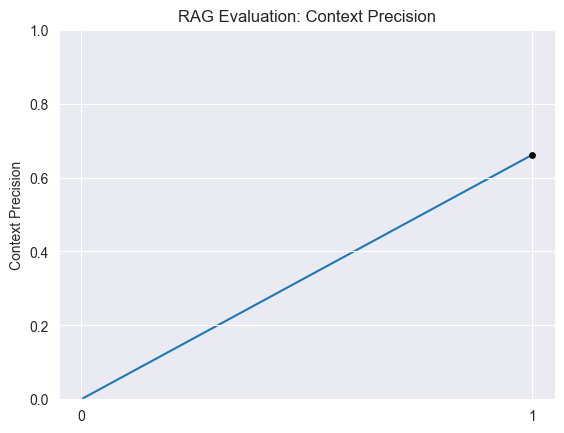

In [34]:
plt_ctx_precision = plot_eval(ctx_precision_df, 'Context Precision')
plt_ctx_precision.savefig('../../../data/rag_eval/results/plots/context_precision.png')

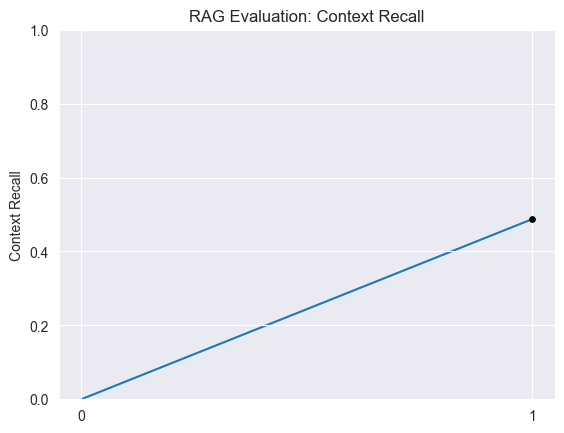

In [35]:
plt_ctx_recall = plot_eval(ctx_recall_df, 'Context Recall')
plt_ctx_recall.savefig('../../../data/rag_eval/results/plots/context_recall.png')